# Case 3: Recheio Customer Data Enrichment & Recommendation Engine

## Overview
This case study focuses on enriching Recheio Cash & Carry’s customer dataset to deliver more relevant product recommendations across digital channels such as the website, mobile app, POS, and contact center. The project combines customer segmentation and association rule mining to develop systems like **Smart Baskets** and **Did You Forget**, enhancing customer experience and increasing Recheio’s share in total customer purchases.

## Business Problem
- Recheio serves two distinct segments (HoReCa and Traditional Retail), each with unique needs.  
- Customer relationship and loyalty are heavily dependent on personalized and insightful interactions.  
- Current data systems are fragmented, limiting the ability to generate impactful recommendations.  
- There is a need to increase **Recheio’s share of wallet** by becoming more relevant in each customer’s purchasing behavior.

---

**This notebook was developed by:**  
- João Venichand - 20211644  
- Gonçalo Custódio - 20211643  
- Diogo Correia - 20211586  
- Duarte Emanuel - 20240564

# 1. Import Libraries

In [171]:
import warnings
import pandas as pd
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
from collections import defaultdict
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from scipy.sparse import csr_matrix
from tabulate import tabulate

from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

# Dataset

In [172]:
data = pd.read_excel('data_with_clusters.xlsx')
data

c:\Users\gonca\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
c:\Users\gonca\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


,Date,Client ID,ID Product,YearMonth,ZIP Code,ID Client Type,Product Description,ID Product Category,Cluster
0,2022-01-02,210100281,224780,2022-01,4400,Café/Pastelaria,FARINHA ESPIGA AMIDO MILHO LUS.2KG,FARINHAS,2
1,2022-01-02,210100281,276806,2022-01,4400,Café/Pastelaria,LARANJA CAL7 (67/76) RCH,FRUTAS FRESCAS,2
2,2022-01-02,210100281,276809,2022-01,4400,Café/Pastelaria,LIMAO CAL 3/4 RCH,FRUTAS FRESCAS,2
3,2022-01-02,210100281,277674,2022-01,4400,Café/Pastelaria,COGUMELO BRANCO MÉDIO RCH,LEGUMES FRESCOS,2
4,2022-01-02,210100281,277917,2022-01,4400,Café/Pastelaria,TOMATE BB 67/82 1CAM RCH,LEGUMES FRESCOS,2
...,...,...,...,...,...,...,...,...,...
884094,2022-12-31,210106386,949447,2022-12,4000,Hotelaria,"BATATA WEDGES C PELE ECOFROST CG 2,5 KG",BATATA,0
884095,2022-12-31,210106386,954062,2022-12,4000,Hotelaria,FIAMBRE FATIADO CASA PORTUGUESA 750G,FIAMBRES,0
884096,2022-12-31,210199916,106702,2022-12,4480,NaN,MOSTARDA DONA SARAH 950GR,MOLHOS,4
884097,2022-12-31,210199916,906800,2022-12,4480,NaN,MOLHO INGLES UNCLE THOMAS 1 LT,MOLHOS,4


In [173]:
data.columns

Index(['Date', 'Client ID', 'ID Product', 'YearMonth', 'ZIP Code',
       'ID Client Type', 'Product Description', 'ID Product Category',
       'Cluster'],
      dtype='object')

In [174]:
horeca = pd.read_excel('horeca_data.xlsx')
horeca

c:\Users\gonca\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
c:\Users\gonca\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


,Date,Client ID,ID Product,YearMonth,ZIP Code,ID Client Type,Product Description,ID Product Category,Recency,Frequency,...,Sunday,YearWeek,Avg_Products_Per_Week,Avg_Products_Per_Purchase,Region,Region_Centro,Region_Lisboa,Region_Norte,Region_Porto,Region_Sul
0,2022-01-02,210105700,941436,2022-01,4400,NaN,* LOMBO DE PORCO C AMEIXAS INOX,PRATO DE CARNE,16,36,...,0.321918,2022-01,7.300000,4.055556,Porto,0,0,0,1,0
1,2022-01-02,210105700,948765,2022-01,4400,NaN,* EMPADÃO DE CARNE INOX,PRATO DE CARNE,16,36,...,0.321918,2022-01,7.300000,4.055556,Porto,0,0,0,1,0
2,2022-01-02,210105700,10001162,2022-01,4400,NaN,JARDINEIRA DE SOJA *,PRATO VEGETARIANO,16,36,...,0.321918,2022-01,7.300000,4.055556,Porto,0,0,0,1,0
3,2022-01-02,210105969,10005577,2022-01,3004,Coletiva/Instituição/Cantina,* CREME DE CENOURA SS 3LT,SOPAS,1,286,...,0.150018,2022-01,105.115385,19.111888,Centro,1,0,0,0,0
4,2022-01-02,210105969,10005957,2022-01,3004,Coletiva/Instituição/Cantina,* CENOURA COZIDA SI,ACOMPANHAMENTO,1,286,...,0.150018,2022-01,105.115385,19.111888,Centro,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10019,2022-12-31,210105969,10006520,2022-12,3004,Coletiva/Instituição/Cantina,* LEG CAMPESTRES SI,ACOMPANHAMENTO,1,286,...,0.150018,2022-52,105.115385,19.111888,Centro,1,0,0,0,0
10020,2022-12-31,210105969,10006532,2022-12,3004,Coletiva/Instituição/Cantina,* MASSA PENNE SI,ACOMPANHAMENTO,1,286,...,0.150018,2022-52,105.115385,19.111888,Centro,1,0,0,0,0
10021,2022-12-31,210105969,10006710,2022-12,3004,Coletiva/Instituição/Cantina,* PERNAS DE FRANGO COZIDAS SI,PRATO DE CARNE,1,286,...,0.150018,2022-52,105.115385,19.111888,Centro,1,0,0,0,0
10022,2022-12-31,210105969,10006758,2022-12,3004,Coletiva/Instituição/Cantina,* COSTELETAS A SALSICHEIRO SI,PRATO DE CARNE,1,286,...,0.150018,2022-52,105.115385,19.111888,Centro,1,0,0,0,0


In [175]:
horeca.columns

Index(['Date', 'Client ID', 'ID Product', 'YearMonth', 'ZIP Code',
       'ID Client Type', 'Product Description', 'ID Product Category',
       'Recency', 'Frequency', 'Monetary', 'Log_Recency', 'Log_Frequency',
       'Log_Monetary', 'Weekday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'YearWeek', 'Avg_Products_Per_Week',
       'Avg_Products_Per_Purchase', 'Region', 'Region_Centro', 'Region_Lisboa',
       'Region_Norte', 'Region_Porto', 'Region_Sul'],
      dtype='object')

# Market Basket Analysis (Association Rules)

In [179]:
def mba(data, cluster_col='Cluster', top_n_products=500, min_support=0.01, max_len=2):
    cluster_rules = {}

    for cluster_id in sorted(data[cluster_col].unique()):
        print(f"Running MBA for Cluster {cluster_id}...")
        
        # Filter data for current cluster
        cluster_data = data[data[cluster_col] == cluster_id]
        
        # Step 1: Basket format
        baskets = cluster_data.groupby(['Client ID', 'Date'])['Product Description'].apply(list).reset_index()

        # Step 2: Encode to binary matrix
        transactions = baskets['Product Description'].tolist()
        te = TransactionEncoder()
        te_matrix = te.fit(transactions).transform(transactions)
        df_basket = pd.DataFrame(te_matrix, columns=te.columns_)

        # Step 3: Top frequent products only
        top_products = df_basket.sum().sort_values(ascending=False).head(top_n_products).index
        df_filtered = df_basket[top_products]

        # Step 4: Apriori + Rules
        try:
            frequent_itemsets = apriori(df_filtered, min_support=min_support, use_colnames=True, max_len=max_len)
            rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
            rules = rules[rules['confidence'] > 0.2].dropna(subset=['antecedents', 'consequents'])
            rules = rules.sort_values(by='lift', ascending=False).reset_index(drop=True)
        except MemoryError:
            print(f"Cluster {cluster_id}: MemoryError — try lowering `top_n_products` or `max_len`.")
            rules = pd.DataFrame()

        cluster_rules[cluster_id] = rules

    return cluster_rules

mba_clusters = mba(data, top_n_products=400, max_len=2)

Running MBA for Cluster 0...
Running MBA for Cluster 1...
Running MBA for Cluster 2...
Running MBA for Cluster 3...
Running MBA for Cluster 4...
Running MBA for Cluster 5...


In [180]:
def format_mba_rules(rules_df, top_n=20):
    if rules_df.empty:
        return pd.DataFrame(columns=['Antecedents', 'Consequents', 'Confidence', 'Lift'])

    formatted_df = rules_df.copy()

    formatted_df['Antecedents'] = formatted_df['antecedents'].apply(lambda x: ', '.join(sorted(x)))
    formatted_df['Consequents'] = formatted_df['consequents'].apply(lambda x: ', '.join(sorted(x)))

    formatted_df = formatted_df[[
        'Antecedents', 'Consequents', 'confidence', 'lift', 'support', 'leverage', 'conviction'
    ]].rename(columns={
        'confidence': 'Confidence',
        'lift': 'Lift',
        'support': 'Support',
        'leverage': 'Leverage',
        'conviction': 'Conviction'
    })

    formatted_df = formatted_df.sort_values(by='Lift', ascending=False).reset_index(drop=True).head(top_n)

    return formatted_df

In [183]:
for cluster_id, rules_df in mba_clusters.items():
    formatted_rules = format_mba_rules(rules_df, top_n=10)
    print(f"\n=== Top Association Rules for Cluster {cluster_id} ===")
    print(tabulate(formatted_rules, headers='keys', tablefmt='pretty', showindex=False))


=== Top Association Rules for Cluster 0 ===
+------------------------------------+------------------------------------+--------------------+--------------------+----------------------+----------------------+--------------------+
|            Antecedents             |            Consequents             |     Confidence     |        Lift        |       Support        |       Leverage       |     Conviction     |
+------------------------------------+------------------------------------+--------------------+--------------------+----------------------+----------------------+--------------------+
|   ICE TEA LIPTON LIMÃO LATA 33CL   |  ICE TEA LIPTON PÊSSEGO LATA 33CL  | 0.6960352422907489 | 44.40340111190197  | 0.010815250872749675 | 0.010571682799090319 | 3.238285710317543  |
|  ICE TEA LIPTON PÊSSEGO LATA 33CL  |   ICE TEA LIPTON LIMÃO LATA 33CL   | 0.6899563318777293 | 44.40340111190197  | 0.010815250872749675 | 0.010571682799090319 | 3.175235408618458  |
|  DOCE BONNE MAMAN MORANG.15X

Graph Visualization Maybe?

## **MBA for Horeca**

In [184]:
def mba_horeca(data, top_n_products=500, min_support=0.01, max_len=2):
    # Step 1: Convert data to basket format (group by order = client + date)
    baskets = data.groupby(['Client ID', 'Date'])['Product Description'].apply(list).reset_index()

    # Step 2: Encode transactions to binary matrix
    transactions = baskets['Product Description'].tolist()
    te = TransactionEncoder()
    te_matrix = te.fit(transactions).transform(transactions)
    df_basket = pd.DataFrame(te_matrix, columns=te.columns_)

    # Step 3: Keep only top N most frequent products
    top_products = df_basket.sum().sort_values(ascending=False).head(top_n_products).index
    df_filtered = df_basket[top_products]

    # Step 4: Apply Apriori with error handling
    try:
        frequent_itemsets = apriori(df_filtered, min_support=min_support, use_colnames=True, max_len=max_len)
        rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
        rules = rules[rules['confidence'] > 0.2].dropna(subset=['antecedents', 'consequents'])
        rules = rules.sort_values(by='lift', ascending=False).reset_index(drop=True)
    except MemoryError:
        print("MemoryError: Try reducing `top_n_products` or `max_len`.")
        rules = pd.DataFrame()

    return rules

horeca_rules = mba_horeca(horeca, top_n_products=400, max_len=2)
horeca_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(* BACALHAU C/ BROA SI),(* BIFE DE PERU C COGUMELOS SI),0.020969,0.011184,0.010718,0.511111,45.701852,1.0,0.010483,2.022579,0.999069,0.500000,0.505582,0.734722
1,(* BIFE DE PERU C COGUMELOS SI),(* BACALHAU C/ BROA SI),0.011184,0.020969,0.010718,0.958333,45.701852,1.0,0.010483,23.496738,0.989182,0.500000,0.957441,0.734722
2,(* CARIL DE GRÃO SI),(* BIFE DE PERU PANADO SI),0.017707,0.019571,0.013514,0.763158,38.993734,1.0,0.013167,4.139588,0.991919,0.568627,0.758430,0.726817
3,(* BIFE DE PERU PANADO SI),(* CARIL DE GRÃO SI),0.019571,0.017707,0.013514,0.690476,38.993734,1.0,0.013167,3.173561,0.993805,0.568627,0.684897,0.726817
4,(* PESCADA DOURADA SI),(* LASANHA DE CARNE SI),0.018639,0.015843,0.011184,0.600000,37.870588,1.0,0.010888,2.460391,0.992086,0.480000,0.593561,0.652941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2289,(* CREME DE LEGUMES SS 3LT),(* CREME DE ABOBORA SS 3LT),0.068500,0.067568,0.021435,0.312925,4.631293,1.0,0.016807,1.357105,0.841736,0.186992,0.263137,0.315083
2290,(* CREME DE ABOBORA SS 3LT),(* CREME DE LEGUMES SS 3LT),0.067568,0.068500,0.021435,0.317241,4.631293,1.0,0.016807,1.364319,0.840895,0.186992,0.267034,0.315083
2291,(* FILETES PERCA-DO-NILO NO FORNO SI),(* CREME DE LEGUMES SS 3LT),0.036347,0.068500,0.011184,0.307692,4.491889,1.0,0.008694,1.345501,0.806697,0.119403,0.256782,0.235479
2292,(* CREME DE CENOURA),(* SOPA DE GRÃO C/ESPINAFRES),0.082479,0.085741,0.030289,0.367232,4.283039,1.0,0.023217,1.444856,0.835426,0.219595,0.307889,0.360246


# **HoReCa Association Rules Analysis**

This analysis focuses on the HoReCa dataset, which includes products marked for professional foodservice use. The top rules reveal strong patterns of co-purchasing, which are useful for understanding purchasing behavior in institutional foodservice.

---

## Key Association Rules

### Ready-to-Serve Main Dishes
- **Rule:** *Bacalhau C/ Broa SI → *Bife de Peru C Cogumelos SI*  
  - Confidence: 51.1%, Lift: 45.7  
- **Reverse Rule:** *Bife de Peru C Cogumelos SI → *Bacalhau C/ Broa SI*  
  - Confidence: 95.8%, Lift: 45.7

**Conclusion:** These two dishes are frequently purchased together, indicating that they are likely part of a recurring menu in foodservice environments.

---

### Vegetarian / Healthy Dishes
- **Rule:** *Caril de Grão SI → *Bife de Peru Panado SI*  
  - Confidence: 76.3%, Lift: 39.0  
- **Rule:** *Sopa de Grão C/Espinafres → *Creme de Cenoura*  
  - Confidence: 35.3%, Lift: 4.28

**Conclusion:** Institutions offering vegetarian or healthy options tend to purchase these items together, showing a focus on balanced meal preparation.

---

### Soups & Starters
- **Rule:** *Creme de Legumes SS 3LT ↔ *Creme de Abóbora SS 3LT*  
  - Confidence: 31.2% – 31.7%, Lift: 4.63

**Conclusion:** Soup items are often purchased together, suggesting efficient meal planning in institutional kitchens.

---

## Overall Insights

- High confidence and lift values indicate that these product pairs are commonly co-purchased, making them ideal for promotions or suggestions.
- Most products are ready-made meals or soups, suggesting that HoReCa clients are mostly canteens, institutional kitchens, or meal prep services.

# Similarity Measures

Jaccard, Cosine and Dice Similarity

In [185]:
def dice_similarity_matrix(X):
    X = X.astype(bool).astype(int)
    X_sparse = csr_matrix(X)
    intersection = X_sparse.T.dot(X_sparse)
    row_sums = X_sparse.sum(axis=0).A1
    dice = 2 * intersection / (row_sums[:, None] + row_sums[None, :])
    dice = dice.toarray()
    np.fill_diagonal(dice, 1.0)
    return pd.DataFrame(dice, index=X.columns, columns=X.columns)

def compute_similarity_matrices(basket_matrix):
    X = (basket_matrix > 0).astype(int)
    # Jaccard similarity (1 - Jaccard distance)
    jaccard_sim = 1 - pairwise_distances(X.T.values, metric='jaccard')
    df_jaccard = pd.DataFrame(jaccard_sim, index=X.columns, columns=X.columns)
    # Cosine similarity
    cosine_sim = cosine_similarity(X.T.values)
    df_cosine = pd.DataFrame(cosine_sim, index=X.columns, columns=X.columns)
    # Dice similarity
    df_dice = dice_similarity_matrix(X)
    return {'jaccard': df_jaccard,'cosine': df_cosine,'dice': df_dice}

def compute_similarity_per_cluster(data, cluster_col='Cluster', top_n_products=100):
    cluster_similarities = {}

    for cluster_id in sorted(data[cluster_col].unique()):
        print(f"Computing Similarities for Cluster {cluster_id}...")
        # Filter data for the current cluster
        cluster_data = data[data[cluster_col] == cluster_id]
        # Step 1: Basket format (Client ID + Product Description)
        baskets = cluster_data.groupby(['Client ID', 'Date'])['Product Description'].apply(list).reset_index()
        # Step 2: Encode to binary matrix (only for product columns)
        transactions = baskets['Product Description'].tolist()
        te = TransactionEncoder()
        te_matrix = te.fit(transactions).transform(transactions)
        # Select only top N frequent products for similarity calculation
        df_basket = pd.DataFrame(te_matrix, columns=te.columns_)
        top_products = df_basket.sum().sort_values(ascending=False).head(top_n_products).index
        df_filtered = df_basket[top_products]
        # Step 3: Compute similarity matrices for the current cluster
        similarities = compute_similarity_matrices(df_filtered)
        # Store the similarities for each cluster
        cluster_similarities[cluster_id] = similarities

    return cluster_similarities

cluster_similarities_dict = compute_similarity_per_cluster(data)

Computing Similarities for Cluster 0...


c:\Users\gonca\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Computing Similarities for Cluster 1...
Computing Similarities for Cluster 2...


c:\Users\gonca\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\Users\gonca\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Computing Similarities for Cluster 3...
Computing Similarities for Cluster 4...


c:\Users\gonca\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\Users\gonca\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Computing Similarities for Cluster 5...


c:\Users\gonca\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [186]:
def build_jaccard_similarity_table(cluster_similarities_dict, threshold=0.1, top_n=10):
    rows = []

    for cluster_id, sims in cluster_similarities_dict.items():
        sim_df = sims['jaccard']
        for i, prod_a in enumerate(sim_df.columns):
            for j, prod_b in enumerate(sim_df.columns):
                if j > i:
                    score = sim_df.iloc[i, j]
                    if score >= threshold:
                        rows.append({
                            'Cluster': cluster_id,
                            'Product A': prod_a,
                            'Product B': prod_b,
                            'Jaccard Similarity': round(score, 4)
                        })

    result_df = pd.DataFrame(rows)
    result_df = (result_df.sort_values(['Cluster', 'Jaccard Similarity'], ascending=[True, False]).groupby('Cluster').head(top_n).reset_index(drop=True))
    return result_df

jaccard_summary_table = build_jaccard_similarity_table(cluster_similarities_dict, threshold=0.1, top_n=10)
display(jaccard_summary_table)

,Cluster,Product A,Product B,Jaccard Similarity
0,0,106-CX.POOL GRD. F&V CPG10,TABULEIRO INOX - COZINHA,0.7761
1,0,IOG.AMANHECER TUTTI FRUTTI 125GR,IOG.AMANHECER BANANA 125GR,0.7572
2,0,IOG.AMANHECER MORANGO 125GR,IOG.AMANHECER TUTTI FRUTTI 125GR,0.7223
3,0,IOG.AMANHECER MORANGO 125GR,IOG.AMANHECER BANANA 125GR,0.6993
4,0,IOG.AMANHECER BANANA 125GR,IOGURTE AMANHECER AROMA COCO 125GR,0.6678
5,0,IOG.AMANHECER MORANGO 125GR,IOGURTE AMANHECER AROMA COCO 125GR,0.6644
6,0,IOG.AMANHECER TUTTI FRUTTI 125GR,IOGURTE AMANHECER AROMA COCO 125GR,0.6608
7,0,REFRIGERANTE COCA COLA ORIGINAL LATA33CL,REFRIGERANTE COCA COLA ZERO LATA 33CL,0.5856
8,0,GELATINA MCHEF MORANGO 4X340GR,GELATINA MCHEF TUTTI FRUTTI 4X340GR,0.4265
9,0,PESSEGO MET EM CALDA ISLAND SUN 820G,ANANAS CALDA UNCLE THOMAS 825GR,0.3704


In [187]:
def build_cosine_similarity_table(cluster_similarities_dict, threshold=0.1, top_n=10):
    rows = []

    for cluster_id, sims in cluster_similarities_dict.items():
        sim_df = sims['cosine']
        for i, prod_a in enumerate(sim_df.columns):
            for j, prod_b in enumerate(sim_df.columns):
                if j > i:
                    score = sim_df.iloc[i, j]
                    if score >= threshold:
                        rows.append({
                            'Cluster': cluster_id,
                            'Product A': prod_a,
                            'Product B': prod_b,
                            'Cosine Similarity': round(score, 4)
                        })

    result_df = pd.DataFrame(rows)
    result_df = (result_df.sort_values(['Cluster', 'Cosine Similarity'], ascending=[True, False]).groupby('Cluster').head(top_n).reset_index(drop=True))
    return result_df

cosine_summary_table = build_cosine_similarity_table(cluster_similarities_dict, threshold=0.1, top_n=10)
display(cosine_summary_table)

,Cluster,Product A,Product B,Cosine Similarity
0,0,106-CX.POOL GRD. F&V CPG10,TABULEIRO INOX - COZINHA,0.8797
1,0,IOG.AMANHECER TUTTI FRUTTI 125GR,IOG.AMANHECER BANANA 125GR,0.8625
2,0,IOG.AMANHECER MORANGO 125GR,IOG.AMANHECER TUTTI FRUTTI 125GR,0.8399
3,0,IOG.AMANHECER MORANGO 125GR,IOG.AMANHECER BANANA 125GR,0.8265
4,0,IOG.AMANHECER MORANGO 125GR,IOGURTE AMANHECER AROMA COCO 125GR,0.8049
5,0,IOG.AMANHECER BANANA 125GR,IOGURTE AMANHECER AROMA COCO 125GR,0.8013
6,0,IOG.AMANHECER TUTTI FRUTTI 125GR,IOGURTE AMANHECER AROMA COCO 125GR,0.7980
7,0,REFRIGERANTE COCA COLA ORIGINAL LATA33CL,REFRIGERANTE COCA COLA ZERO LATA 33CL,0.7410
8,0,GELATINA MCHEF MORANGO 4X340GR,GELATINA MCHEF TUTTI FRUTTI 4X340GR,0.6058
9,0,PESSEGO MET EM CALDA ISLAND SUN 820G,ANANAS CALDA UNCLE THOMAS 825GR,0.5407


In [188]:
def build_dice_similarity_table(cluster_similarities_dict, threshold=0.1, top_n=10):
    rows = []

    for cluster_id, sims in cluster_similarities_dict.items():
        sim_df = sims['dice']
        for i, prod_a in enumerate(sim_df.columns):
            for j, prod_b in enumerate(sim_df.columns):
                if j > i:
                    score = sim_df.iloc[i, j]
                    if score >= threshold:
                        rows.append({
                            'Cluster': cluster_id,
                            'Product A': prod_a,
                            'Product B': prod_b,
                            'Dice Similarity': round(score, 4)
                        })

    result_df = pd.DataFrame(rows)
    result_df = (result_df.sort_values(['Cluster', 'Dice Similarity'], ascending=[True, False]).groupby('Cluster').head(top_n).reset_index(drop=True))
    return result_df

dice_summary_table = build_dice_similarity_table(cluster_similarities_dict, threshold=0.1, top_n=10)
display(dice_summary_table)

,Cluster,Product A,Product B,Dice Similarity
0,0,106-CX.POOL GRD. F&V CPG10,TABULEIRO INOX - COZINHA,0.8739
1,0,IOG.AMANHECER TUTTI FRUTTI 125GR,IOG.AMANHECER BANANA 125GR,0.8618
2,0,IOG.AMANHECER MORANGO 125GR,IOG.AMANHECER TUTTI FRUTTI 125GR,0.8387
3,0,IOG.AMANHECER MORANGO 125GR,IOG.AMANHECER BANANA 125GR,0.8231
4,0,IOG.AMANHECER BANANA 125GR,IOGURTE AMANHECER AROMA COCO 125GR,0.8008
5,0,IOG.AMANHECER MORANGO 125GR,IOGURTE AMANHECER AROMA COCO 125GR,0.7983
6,0,IOG.AMANHECER TUTTI FRUTTI 125GR,IOGURTE AMANHECER AROMA COCO 125GR,0.7958
7,0,REFRIGERANTE COCA COLA ORIGINAL LATA33CL,REFRIGERANTE COCA COLA ZERO LATA 33CL,0.7386
8,0,GELATINA MCHEF MORANGO 4X340GR,GELATINA MCHEF TUTTI FRUTTI 4X340GR,0.5979
9,0,PESSEGO MET EM CALDA ISLAND SUN 820G,ANANAS CALDA UNCLE THOMAS 825GR,0.5406


## **Similarity Measures - HORECA**

In [190]:
def compute_similarity_for_horeca(horeca_data, top_n_products=100):
    print("Computing Similarities for HoReCa segment...")

    # Step 1: Basket format
    baskets = horeca_data.groupby(['Client ID', 'Date'])['Product Description'].apply(list).reset_index()

    # Step 2: Binary matrix transformation
    transactions = baskets['Product Description'].tolist()
    te = TransactionEncoder()
    te_matrix = te.fit(transactions).transform(transactions)
    df_basket = pd.DataFrame(te_matrix, columns=te.columns_)

    # Step 3: Select most frequent products
    top_products = df_basket.sum().sort_values(ascending=False).head(top_n_products).index
    df_filtered = df_basket[top_products]

    # Step 4: Compute similarity matrices
    similarity_dict = compute_similarity_matrices(df_filtered)

    return similarity_dict

horeca_similarity = compute_similarity_for_horeca(horeca, top_n_products=100)

def build_horeca_similarity_table(sim_df, metric_name='Similarity', threshold=0.1, top_n=20):
    rows = []

    for i, prod_a in enumerate(sim_df.columns):
        for j, prod_b in enumerate(sim_df.columns):
            if j > i:
                score = sim_df.iloc[i, j]
                if score >= threshold:
                    rows.append({
                        'Product A': prod_a,
                        'Product B': prod_b,
                        f'{metric_name}': round(score, 4)
                    })

    result_df = pd.DataFrame(rows)
    result_df = result_df.sort_values(by=f'{metric_name}', ascending=False).head(top_n)
    return result_df

Computing Similarities for HoReCa segment...


c:\Users\gonca\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [191]:
horeca_jaccard_table = build_horeca_similarity_table(horeca_similarity['jaccard'], metric_name='Jaccard', threshold=0.1, top_n=20)
display(horeca_jaccard_table)

,Product A,Product B,Jaccard
714,*BACALHAU COM NATAS PP KG,* GRELOS SALTEADOS PP KG,0.9123
945,* FARFALLE C LEG SAT E SALMÃO PP KG,* BIFE DE PERU C COGUMELOS PP KG,0.8585
0,* CENOURA COZIDA SI,* BATATINHA COZIDA SI,0.8450
1,* CENOURA COZIDA SI,* ARROZ BRANCO SI,0.7860
507,* PESCADA COZIDA SI,* FEIJÃO VERDE COZIDO SI,0.6624
905,*PERNAS DE FRANGO NO FORNO SI,* PERNAS DE FRANGO COZIDAS SI,0.6491
60,* BATATINHA COZIDA SI,* ARROZ BRANCO SI,0.6458
121,* ARROZ BRANCO SI,* BRÒCULOS COZIDOS SI,0.6371
3,* CENOURA COZIDA SI,* BRÒCULOS COZIDOS SI,0.6370
861,* ARROZ DE CENOURA SI,* PERNAS DE FRANGO COZIDAS SI,0.6017


In [192]:
horeca_cosine_table = build_horeca_similarity_table(horeca_similarity['cosine'], metric_name='Cosine', threshold=0.1, top_n=20)
display(horeca_cosine_table)

,Product A,Product B,Cosine
742,*BACALHAU COM NATAS PP KG,* GRELOS SALTEADOS PP KG,0.9548
974,* FARFALLE C LEG SAT E SALMÃO PP KG,* BIFE DE PERU C COGUMELOS PP KG,0.9242
0,* CENOURA COZIDA SI,* BATATINHA COZIDA SI,0.9187
1,* CENOURA COZIDA SI,* ARROZ BRANCO SI,0.8857
518,* PESCADA COZIDA SI,* FEIJÃO VERDE COZIDO SI,0.7974
3,* CENOURA COZIDA SI,* BRÒCULOS COZIDOS SI,0.7973
934,*PERNAS DE FRANGO NO FORNO SI,* PERNAS DE FRANGO COZIDAS SI,0.7894
61,* BATATINHA COZIDA SI,* ARROZ BRANCO SI,0.7853
122,* ARROZ BRANCO SI,* BRÒCULOS COZIDOS SI,0.7830
1575,* ARROZ DE TOMATE SI,* PESCADA DOURADA SI,0.7708


In [193]:
horeca_dice_table = build_horeca_similarity_table(horeca_similarity['dice'], metric_name='Dice', threshold=0.1, top_n=20)
display(horeca_dice_table)

,Product A,Product B,Dice
736,*BACALHAU COM NATAS PP KG,* GRELOS SALTEADOS PP KG,0.9541
968,* FARFALLE C LEG SAT E SALMÃO PP KG,* BIFE DE PERU C COGUMELOS PP KG,0.9239
0,* CENOURA COZIDA SI,* BATATINHA COZIDA SI,0.9160
1,* CENOURA COZIDA SI,* ARROZ BRANCO SI,0.8802
517,* PESCADA COZIDA SI,* FEIJÃO VERDE COZIDO SI,0.7969
928,*PERNAS DE FRANGO NO FORNO SI,* PERNAS DE FRANGO COZIDAS SI,0.7872
61,* BATATINHA COZIDA SI,* ARROZ BRANCO SI,0.7848
122,* ARROZ BRANCO SI,* BRÒCULOS COZIDOS SI,0.7784
3,* CENOURA COZIDA SI,* BRÒCULOS COZIDOS SI,0.7783
884,* ARROZ DE CENOURA SI,* PERNAS DE FRANGO COZIDAS SI,0.7513


# Page Rank

In [194]:
def pagerank(data, cluster_col='Cluster', top_n_products=200, top_n_scores=10):
    results = {}

    for cluster_id in sorted(data[cluster_col].unique()):
        print(f"\n - Cluster {cluster_id} — Top {top_n_scores} Products by PageRank")

        # Step 1: Filter and sort by Client and Date
        cluster_data = data[data[cluster_col] == cluster_id].copy()
        cluster_data['Date'] = pd.to_datetime(cluster_data['Date'])
        cluster_data.sort_values(by=['Client ID', 'Date'], inplace=True)

        # Step 2: Build directed co-occurrence edges
        transitions = defaultdict(int)

        for (client_id, date), group in cluster_data.groupby(['Client ID', 'Date']):
            product_sequence = group['Product Description'].tolist()
            # Create edges between consecutive products
            for i in range(len(product_sequence) - 1):
                from_item = product_sequence[i]
                to_item = product_sequence[i + 1]
                transitions[(from_item, to_item)] += 1

        # Step 3: Build directed graph
        G = nx.DiGraph()
        for (src, tgt), weight in transitions.items():
            G.add_edge(src, tgt, weight=weight)

        # Step 4: Keep only top N nodes
        top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:top_n_products]
        top_node_names = set(n for n, _ in top_nodes)
        G = G.subgraph(top_node_names).copy()

        # Step 5: Run PageRank
        pagerank = nx.pagerank(G, alpha=0.85, weight='weight')
        pr_series = pd.Series(pagerank).sort_values(ascending=False).head(top_n_scores)
        results[cluster_id] = pr_series

        # Display
        print(tabulate(pr_series.reset_index().rename(columns={"index": "Product", 0: "Score"}),
                       headers='keys', tablefmt='fancy_grid'))

    return results

In [195]:
pagerank_results = pagerank(data, top_n_products=100, top_n_scores=10)


 - Cluster 0 — Top 10 Products by PageRank
╒════╤══════════════════════════════════════════╤═══════════╕
│    │ Product                                  │     Score │
╞════╪══════════════════════════════════════════╪═══════════╡
│  0 │ CREME VEGETAL MCHEF KG                   │ 0.111473  │
├────┼──────────────────────────────────────────┼───────────┤
│  1 │ FIAMBRE FATIADO CASA PORTUGUESA 750G     │ 0.073735  │
├────┼──────────────────────────────────────────┼───────────┤
│  2 │ PESSEGO MET EM CALDA ISLAND SUN 820G     │ 0.0715331 │
├────┼──────────────────────────────────────────┼───────────┤
│  3 │ POLPA TOMATE MCHEF 1LT                   │ 0.0680282 │
├────┼──────────────────────────────────────────┼───────────┤
│  4 │ SACO LIXO AMANHECER FF 50L 15 UN         │ 0.0498984 │
├────┼──────────────────────────────────────────┼───────────┤
│  5 │ MANTEIGA MIMOSA C/SAL 100X8GR            │ 0.0453974 │
├────┼──────────────────────────────────────────┼───────────┤
│  6 │ V. BCO ABDEGAS 11,5

Visualization of Top Products

C:\Users\gonca\AppData\Local\Temp\ipykernel_11012\2655122517.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(cluster_ids))
c:\Users\gonca\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


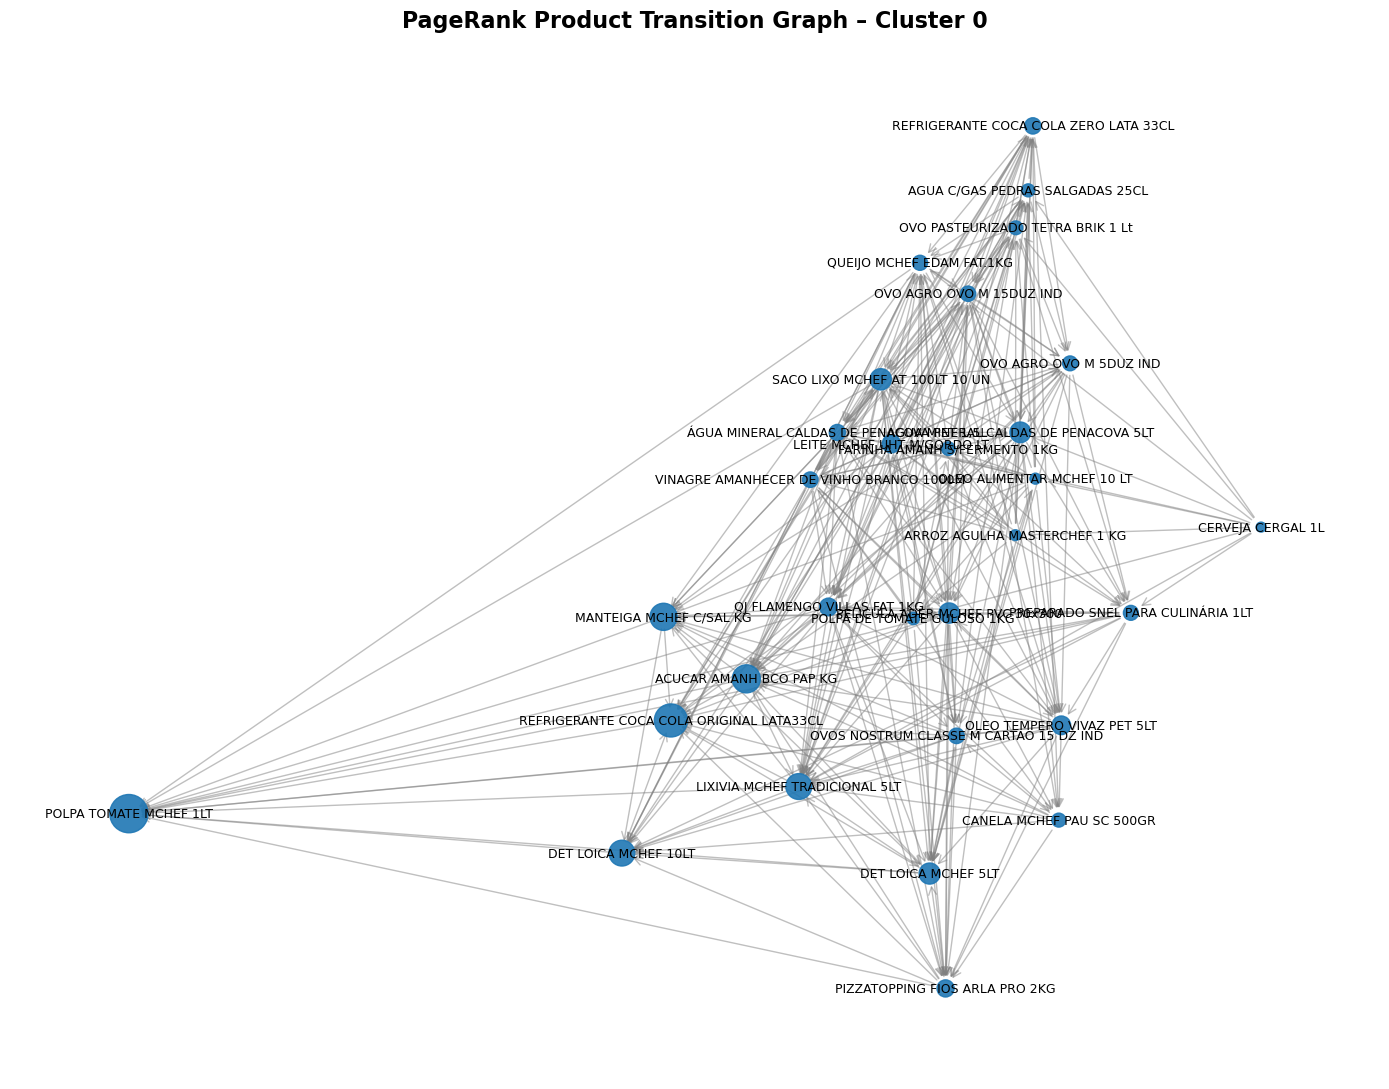

c:\Users\gonca\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


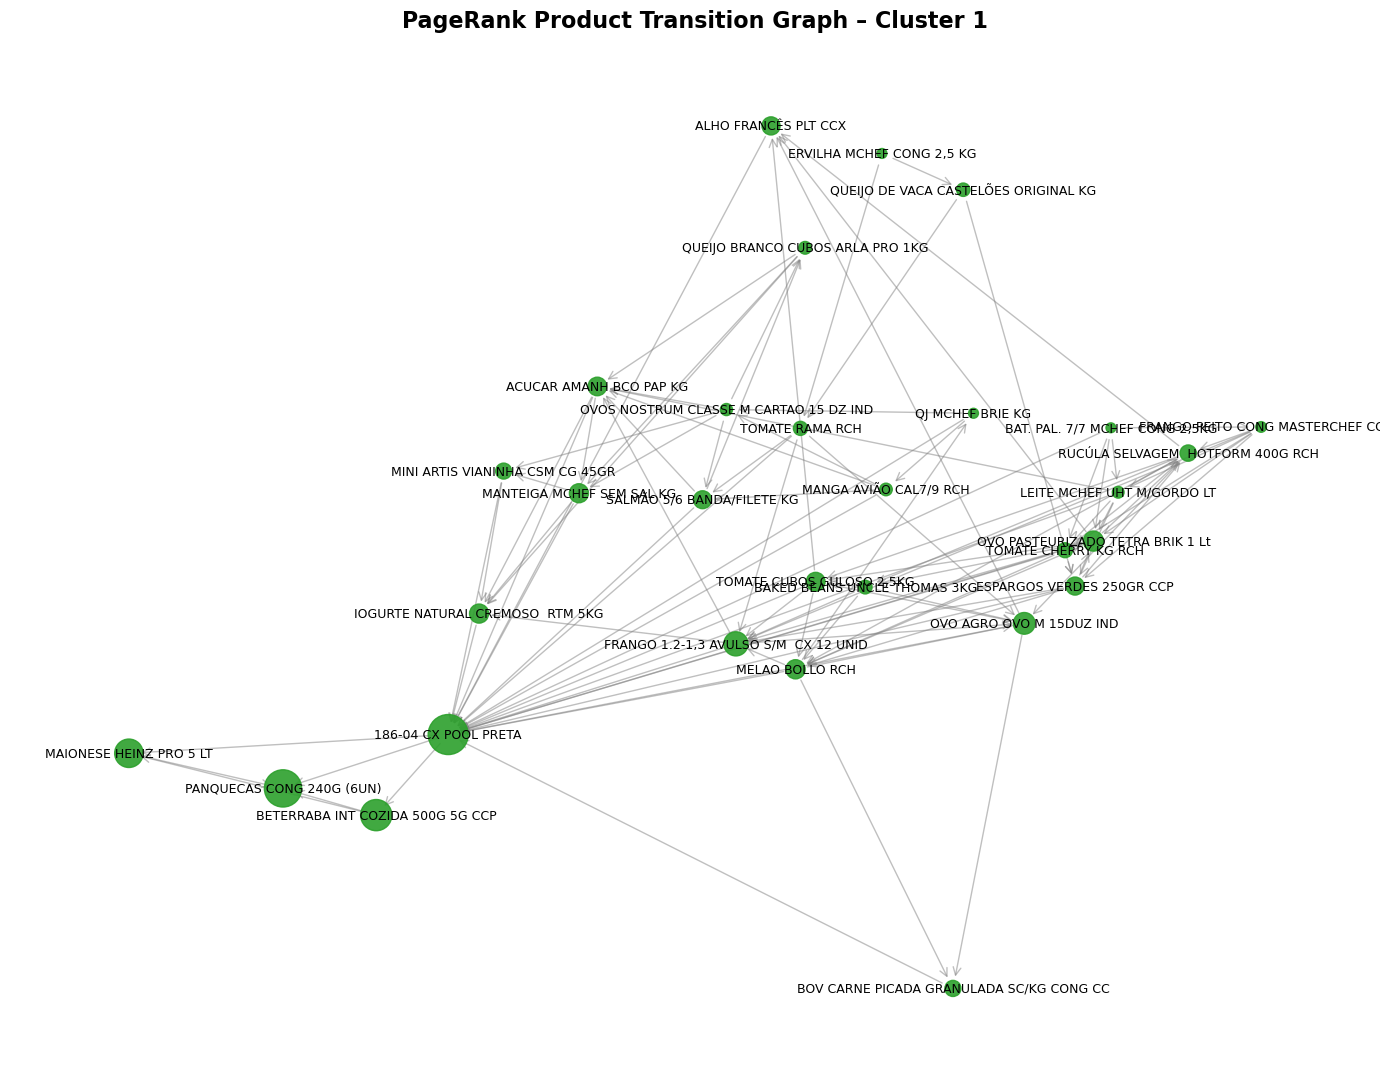

c:\Users\gonca\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


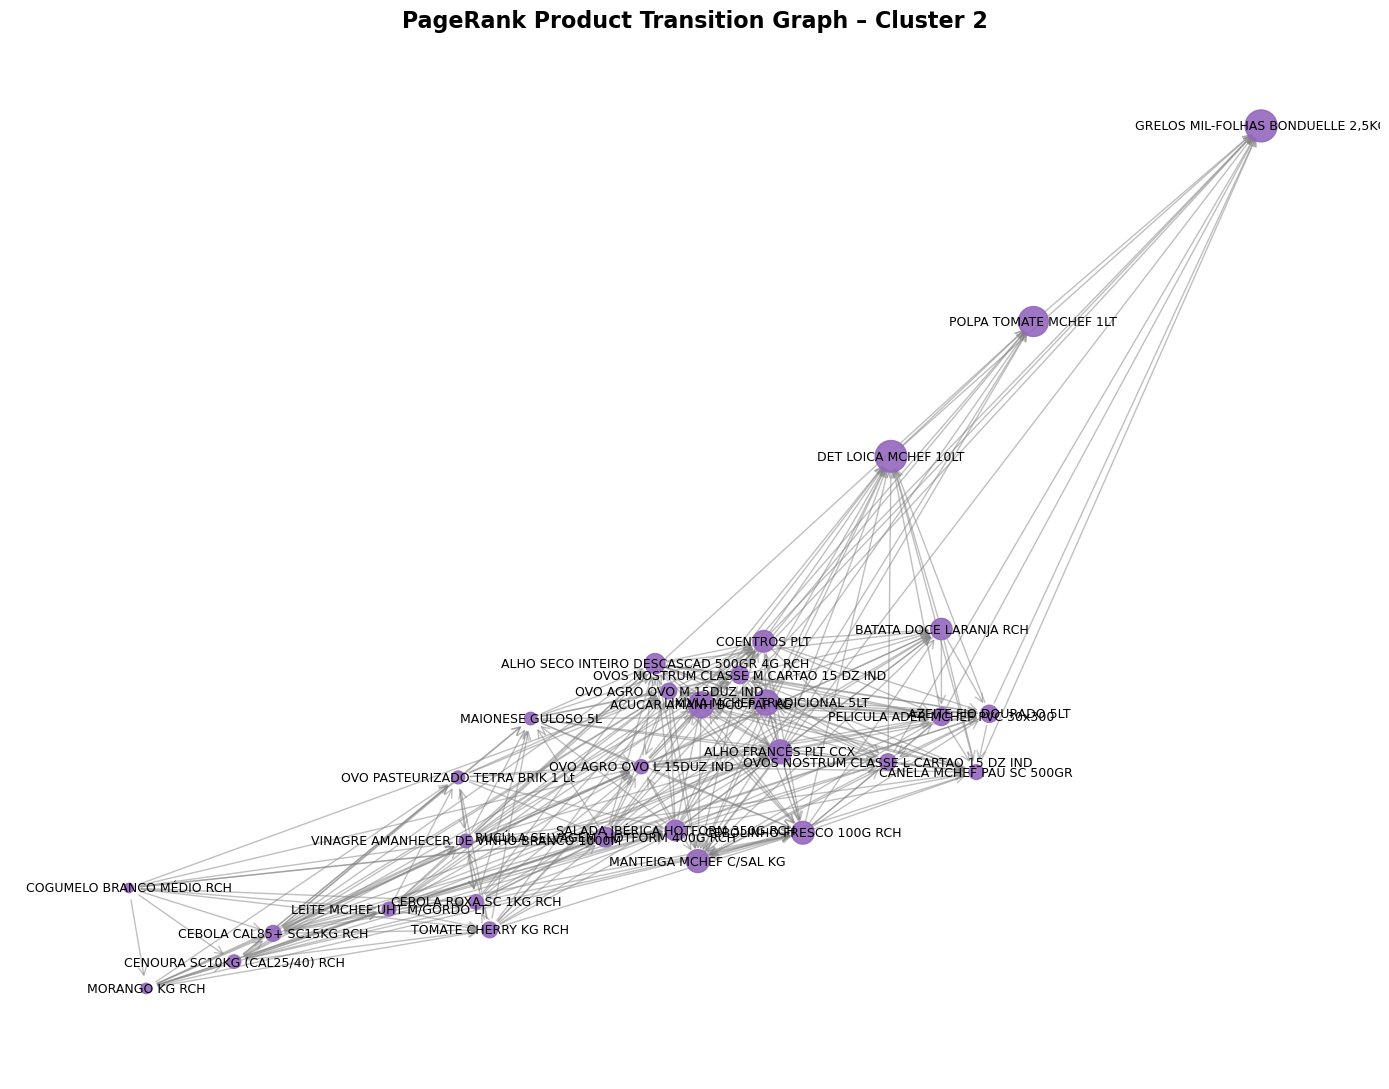

c:\Users\gonca\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


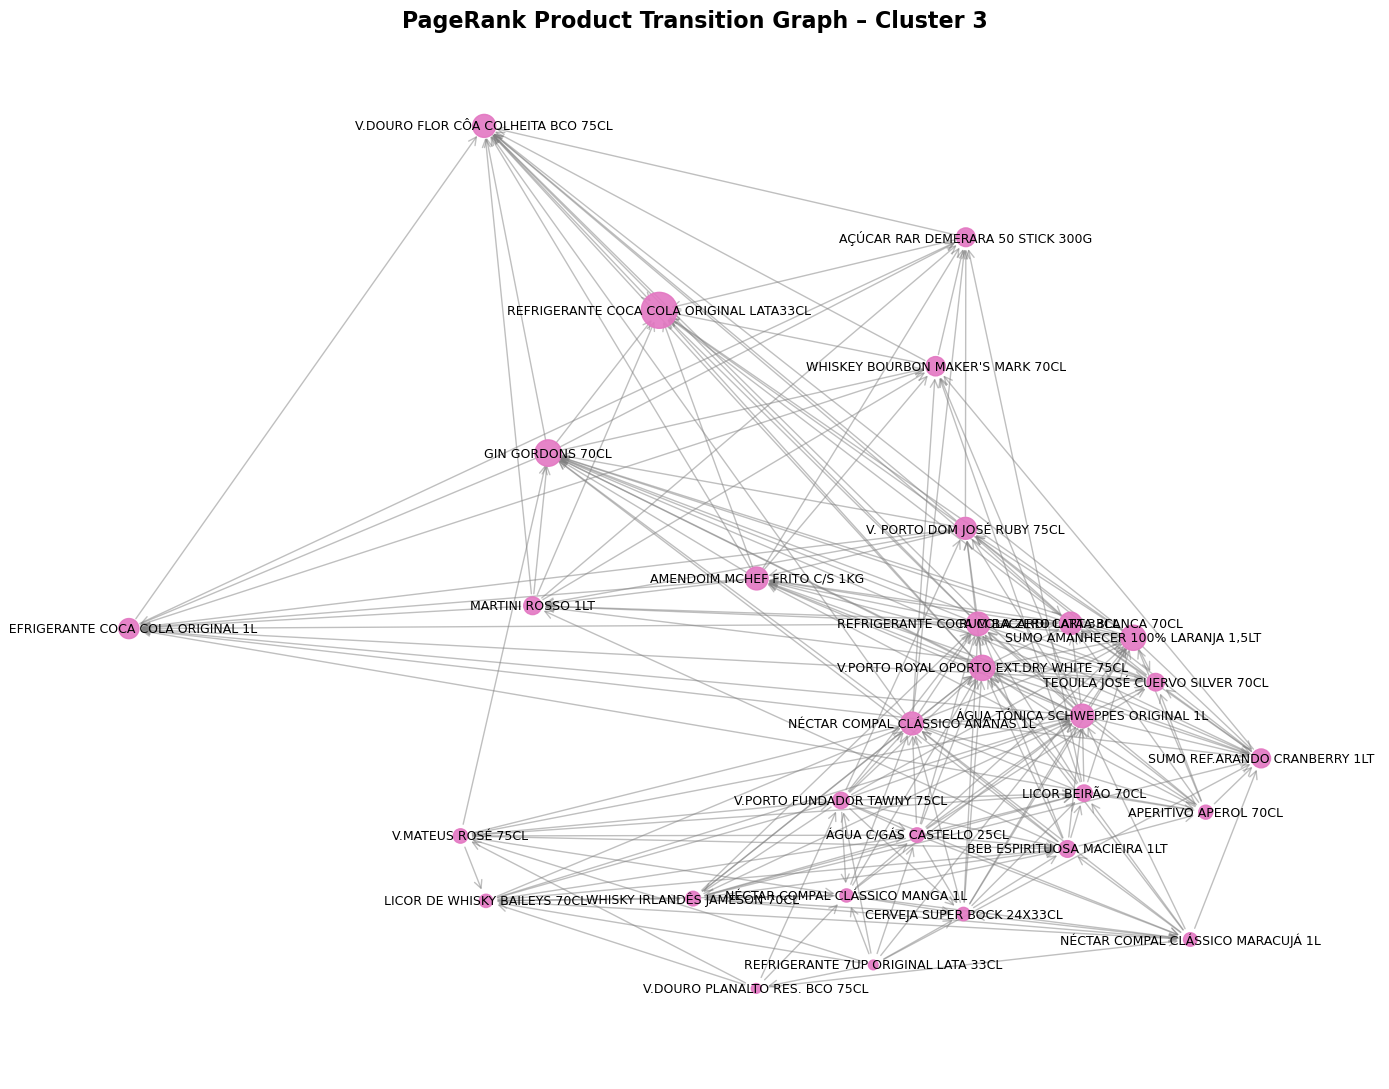

c:\Users\gonca\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


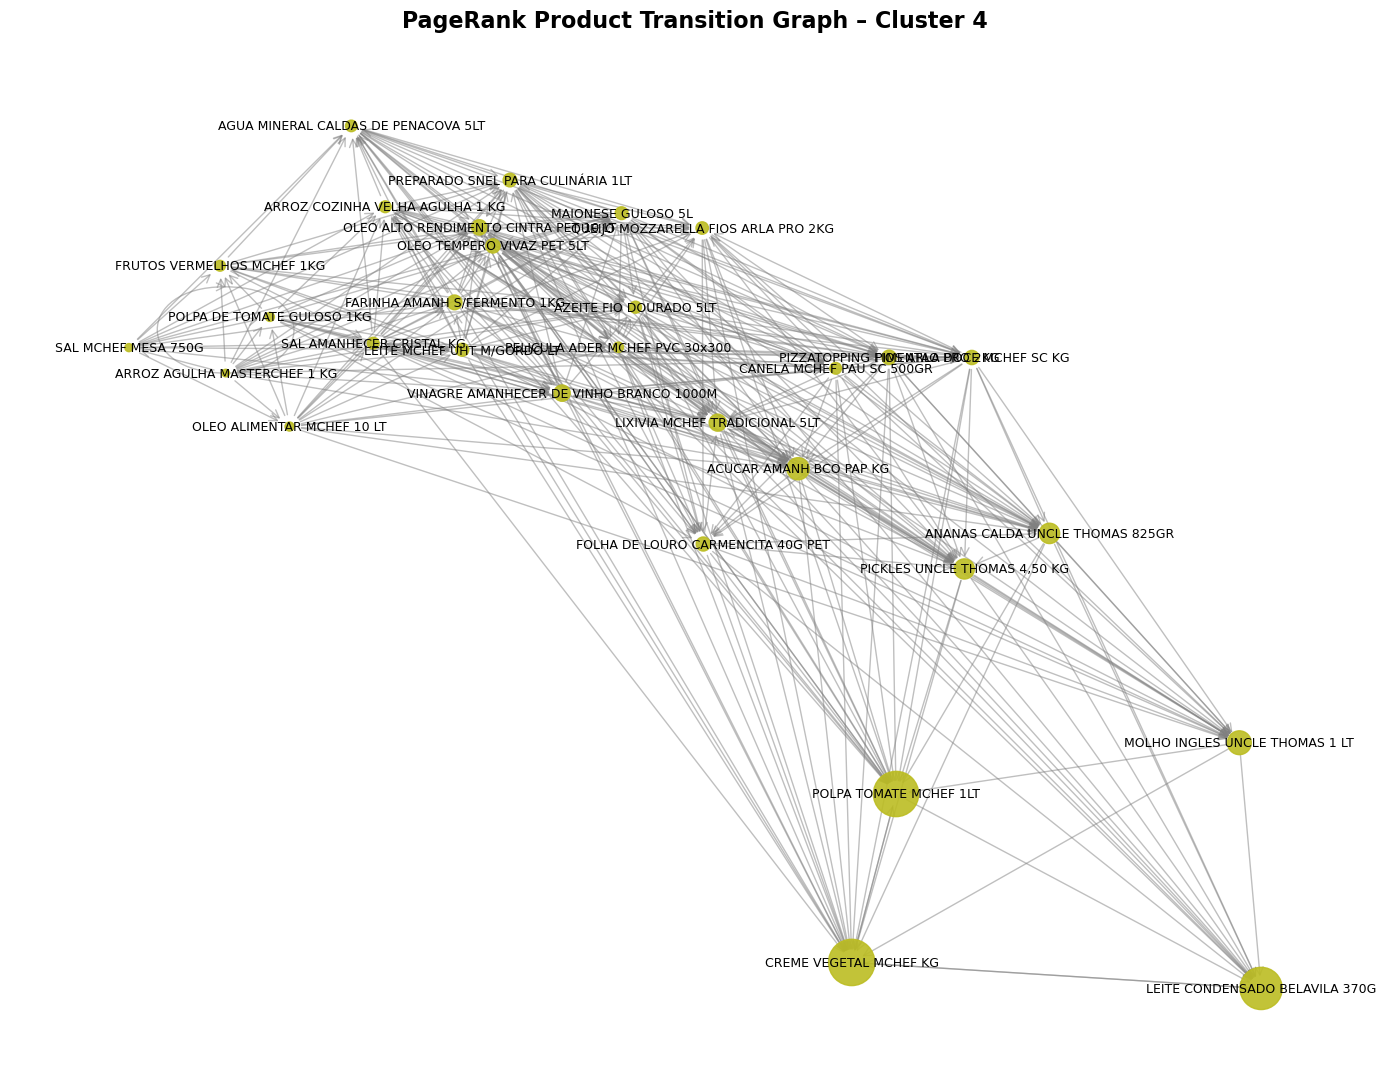

c:\Users\gonca\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


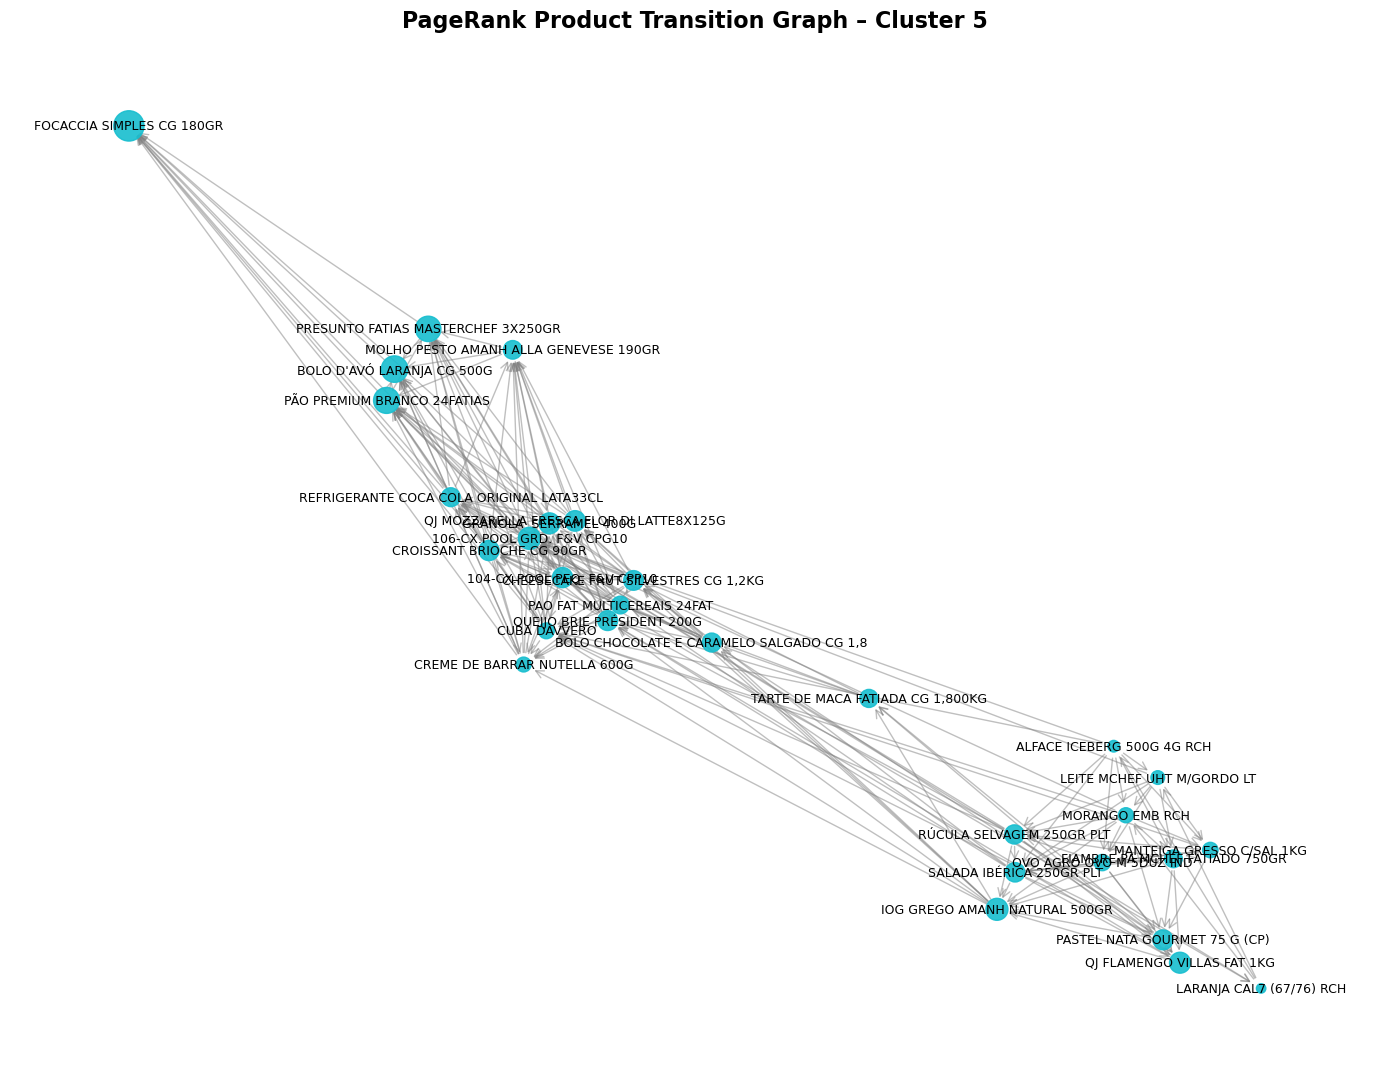

In [197]:
def pagerank_visualizations(data, cluster_col='Cluster', top_n_products=30, layout='spring'):
    import matplotlib.pyplot as plt
    import networkx as nx
    from collections import defaultdict
    from matplotlib import cm

    cluster_ids = sorted(data[cluster_col].unique())
    cmap = cm.get_cmap('tab10', len(cluster_ids))

    for idx, cluster_id in enumerate(cluster_ids):
        cluster_data = data[data[cluster_col] == cluster_id].copy()
        cluster_data['Date'] = pd.to_datetime(cluster_data['Date'])
        cluster_data.sort_values(by=['Client ID', 'Date'], inplace=True)

        transitions = defaultdict(int)
        for (client_id, date), group in cluster_data.groupby(['Client ID', 'Date']):
            sequence = group['Product Description'].tolist()
            for i in range(len(sequence) - 1):
                transitions[(sequence[i], sequence[i + 1])] += 1

        G = nx.DiGraph()
        for (src, tgt), weight in transitions.items():
            G.add_edge(src, tgt, weight=weight)

        top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:top_n_products]
        top_node_names = {n for n, _ in top_nodes}
        G = G.subgraph(top_node_names).copy()

        if len(G.nodes) == 0:
            print(f"Cluster {cluster_id}: No data to visualize.")
            continue

        # PageRank for node sizing
        pr = nx.pagerank(G, alpha=0.85, weight='weight')
        node_sizes = [6000 * pr[n] for n in G.nodes]

        pos = nx.spring_layout(G, seed=42, k=0.6)

        plt.figure(figsize=(14, 11))
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=cmap(idx), alpha=0.9)
        nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=14, edge_color='gray', alpha=0.5)
        nx.draw_networkx_labels(G, pos, font_size=9)

        plt.title(f"PageRank Product Transition Graph – Cluster {cluster_id}", fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
pagerank_visualizations(data, top_n_products=30)

# Integrated Recommendation System

## **SMART BASKET (Check-In)**

In [198]:
def smart_basket_recommendations_clustered(cluster_similarities_dict, pagerank_results, top_n=5, similar_n=3, similarity_metric='cosine'):
    all_recommendations = []

    for cluster_id in sorted(pagerank_results.keys()):
        if cluster_id not in cluster_similarities_dict:
            continue
        top_products = pagerank_results[cluster_id].head(top_n).index.tolist()
        sim_matrix = cluster_similarities_dict[cluster_id][similarity_metric]

        for product in top_products:
            if product not in sim_matrix.index:
                continue 

            similar_products = sim_matrix[product].drop(index=product).sort_values(ascending=False)
            filtered_similars = [p for p in similar_products.index if p not in top_products][:similar_n]

            all_recommendations.append({
                'Cluster': cluster_id,
                'Central Product (PageRank)': product,
                'Recommended due to similarity': filtered_similars
            })

    return pd.DataFrame(all_recommendations)

In [199]:
smart_basket_df = smart_basket_recommendations_clustered(
    cluster_similarities_dict,
    pagerank_results,
    top_n=5,
    similar_n=3,
    similarity_metric='cosine'
)

print("Smart Basket Recommendations (Check-In):")
display(smart_basket_df)

Smart Basket Recommendations (Check-In):


,Cluster,Central Product (PageRank),Recommended due to similarity
0,0,FIAMBRE FATIADO CASA PORTUGUESA 750G,"[QJ FLAMENGO VILLAS FAT 1KG, QUEIJO MCHEF EDAM..."
1,0,PESSEGO MET EM CALDA ISLAND SUN 820G,"[ANANAS CALDA UNCLE THOMAS 825GR, GELATINA MCH..."
2,0,POLPA TOMATE MCHEF 1LT,"[GELATINA MCHEF TUTTI FRUTTI 4X340GR, GELATINA..."
3,0,SACO LIXO AMANHECER FF 50L 15 UN,"[SACO LIXO MCHEF AT 100LT 10 UN, AGUA BI-DESMI..."
4,1,186-04 CX POOL PRETA,"[MORANGO KG RCH, COGUMELO BRANCO MÉDIO RCH, PE..."
5,1,BETERRABA INT COZIDA 500G 5G CCP,"[MORANGO KG RCH, COGUMELO BRANCO MÉDIO RCH, PE..."
6,1,AZEITO.PRETAS S/CAROÇO EXCELENCIA 3KG,"[OVO PASTEURIZADO TETRA BRIK 1 Lt, IOGURTE NAT..."
7,2,"BROCULO 40-60 CONG 2,5 KG","[COUVE FLOR MCHEF 2,5KG, LEITE MCHEF UHT M/GOR..."
8,2,"GRELOS MIL-FOLHAS BONDUELLE 2,5KG","[ABACAXI CAL5/6 DELMONTE RCH, TOMATE CHERRY KG..."
9,2,POLPA TOMATE MCHEF 1LT,"[COUVE CORACAO DE BOI C/FOLHAS RCH, CENOURA SC..."


# **"DID YOU FORGET?" (Check-Out)**

In [ ]:
def checkout_recommendations(current_basket, rules_df, similarities, top_n=2, similarity_metric='dice'):
    recommendations = []

    for product in current_basket:
        recs_for_product = []

        for _, rule in rules_df.iterrows():
            antecedents = set(rule['antecedents'])
            consequents = set(rule['consequents'])

            if product in antecedents and not consequents.issubset(current_basket):
                for item in consequents:
                    if item not in current_basket and item not in recs_for_product:
                        if item in similarities[similarity_metric].columns:
                            similar_items = similarities[similarity_metric][item].drop(index=item).sort_values(ascending=False)
                            similar_filtered = [i for i in similar_items.index if i not in current_basket][:top_n]
                        else:
                            similar_filtered = []

                        recommendations.append({
                            'Basket Product': product,
                            'Recommended Item': item,
                            'Confidence': round(rule['confidence'], 3),
                            'Lift': round(rule['lift'], 2),
                            'Similar popular items': ', '.join(similar_filtered)
                        })
                        recs_for_product.append(item)

                        if len(recs_for_product) >= top_n:
                            break
            if len(recs_for_product) >= top_n:
                break

    return pd.DataFrame(recommendations)

In [ ]:
# Step 1: Get a random cluster ID
available_clusters = list(mba_clusters.keys())  # keys are cluster IDs like 0, 1, 2, ...
random_cluster = random.choice(available_clusters)

# Step 2: Extract rules and similarities for the chosen cluster
rules_df = mba_clusters[random_cluster]
similarities = cluster_similarities_dict[random_cluster]

# Step 3: Generate random basket
all_products = list(set(item for rule in rules_df.itertuples() for item in rule.antecedents.union(rule.consequents)))
current_basket = set(random.sample(all_products, k=min(5, len(all_products))))

# Step 4: Run recommendations
checkout_df = checkout_recommendations(current_basket, rules_df, similarities, top_n=2, similarity_metric='cosine')

print(f"Randomly selected Cluster: {random_cluster}")
print("Current Basket:", current_basket)
display(checkout_df)

# **MCCV**

In [ ]:
def monte_carlo_validation_metrics(data, mba_clusters, cluster_similarities_dict, iterations=10, cutoff='2022-10-01', top_n=10, similarity_metric='cosine'):
    clients = data['Client ID'].unique()
    hit_counts = []
    precision_scores = []
    recall_scores = []

    for i in range(iterations):
        sampled_clients = random.sample(list(clients), k=int(len(clients) * 0.1))
        iteration_hits = 0
        iteration_precision = []
        iteration_recall = []

        for client_id in sampled_clients:
            client_data = data[data['Client ID'] == client_id]
            if client_data.empty or 'Cluster' not in client_data.columns:
                continue

            cluster_id = client_data['Cluster'].mode()[0]
            rules_df = mba_clusters.get(cluster_id)
            similarities = cluster_similarities_dict.get(cluster_id)

            if rules_df is None or similarities is None:
                continue

            client_data.loc[:, 'Date'] = pd.to_datetime(client_data['Date'])
            obs_data = client_data[client_data['Date'] < cutoff]
            test_data = client_data[client_data['Date'] >= cutoff]

            if obs_data.empty or test_data.empty:
                continue

            obs_basket = obs_data.groupby('Date')['Product Description'].apply(list)
            if obs_basket.empty:
                continue
            obs_basket = obs_basket.sample(1).values[0]

            future_basket = test_data.groupby('Date')['Product Description'].apply(list)
            if future_basket.empty:
                continue
            future_basket = future_basket.sample(1).values[0]

            if len(future_basket) < 2:
                continue

            held_out = set(future_basket)
            current_basket = set(obs_basket)

            recs = checkout_recommendations(current_basket, rules_df, similarities, top_n=top_n, similarity_metric=similarity_metric)

            if recs.empty or 'Recommended Item' not in recs.columns:
                continue

            recommended_items = set(recs['Recommended Item'])
            hits = held_out.intersection(recommended_items)

            precision = len(hits) / top_n
            recall = len(hits) / len(held_out)

            iteration_hits += len(hits) > 0
            iteration_precision.append(precision)
            iteration_recall.append(recall)

        if iteration_precision:
            avg_precision = sum(iteration_precision) / len(iteration_precision)
            avg_recall = sum(iteration_recall) / len(iteration_recall)
            precision_scores.append(avg_precision)
            recall_scores.append(avg_recall)
            hit_counts.append(iteration_hits / len(sampled_clients))

            print(f"Iteration {i+1:02d} | Hit Rate: {iteration_hits / len(sampled_clients):.2%} "
                  f"| Precision: {avg_precision:.2%} | Recall: {avg_recall:.2%}")

    if hit_counts:
        print(f"\nAvg Hit Rate: {sum(hit_counts) / len(hit_counts):.2%}")
        print(f"Avg Precision@{top_n}: {sum(precision_scores) / len(precision_scores):.2%}")
        print(f"Avg Recall: {sum(recall_scores) / len(recall_scores):.2%}")
    else:
        print("Not enough data to evaluate.")

In [ ]:
monte_carlo_validation_metrics(data=data, mba_clusters=mba_clusters, cluster_similarities_dict=cluster_similarities_dict, iterations=25, cutoff='2022-12-01', top_n=15, similarity_metric='cosine')